# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Cluster brain structures into circuits by PMI-weighted co-occurrences with mental function terms.
2. Identify the mental function terms most highly associated to each circuit over a range of list lengths.
3. Select the list length for each circuit that maximizes word-structure classification performance. 
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import utilities, ontology

In [2]:
suffix = "_nn"

## Cluster range to visualize

In [3]:
circuit_counts = range(2, 16)

## Brain activation coordinates

In [4]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Terms for mental functions

In [5]:
version = 190325
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)

In [6]:
lexicon = utilities.load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns)))
len(lexicon)

1683

In [7]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=1683


## Document splits

In [8]:
train, val = [[int(pmid.strip()) 
               for pmid in open("../data/splits/{}.txt".format(split))] 
                    for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Name the domains

## Select the term with highest degree centrality

Also ensure that names are unique across domains in the clustering solution

In [9]:
title_df = pd.read_csv("../lexicon/labels_cogneuro.csv", index_col=None, header=0)
term2title = {term: title for term, title in zip(title_df["TERM"], title_df["TITLE"])}

In [10]:
k2terms, k2titles, k2name = {}, {}, {}
for k in circuit_counts:
    print("Processing k={}".format(k))
    lists, circuits = ontology.load_ontology(k, suffix=suffix)
    k2terms[k] = {i: list(set(lists.loc[lists["CLUSTER"] == i+1, "TOKEN"])) for i in range(k)}
    k2titles[k] = {}
    for i, terms in k2terms[k].items():
        k2titles[k][i] = [term2title[term] for term in terms]
    k2name[k] = {i+1: "" for i in range(k)}
    names, degs = [""]*k, [0]*k
    while "" in names:
        for i in range(k):
            degrees = ontology.term_degree_centrality(i+1, lists, dtm_bin, dtm_bin.index)
            degrees.index = [term2title[term] for term in degrees.index]
            degrees = degrees.loc[k2titles[k][i]].sort_values(ascending=False)
            name = degrees.index[0]
            if name not in names:
                names[i] = name
                degs[i] = max(degrees)
                k2name[k][i+1] = name
            elif name in names:
                name_idx = names.index(name)
                if degs[name_idx] > degs[i]:
                    k2titles[k][i] = [term for term in k2titles[k][i] if term != name]

Processing k=2
Processing k=3
Processing k=4
Processing k=5
Processing k=6
Processing k=7
Processing k=8
Processing k=9
Processing k=10
Processing k=11
Processing k=12
Processing k=13
Processing k=14
Processing k=15


## Sort by predetermined semantic ordering

In [11]:
names = set()
for k in circuit_counts:
    for i in range(k):
        names.add(k2name[k][i+1].replace("_", " "))
names = sorted(list(names))
names

['Anticipation',
 'Arousal',
 'Cognition',
 'Cognitive Process',
 'Emotion',
 'Episodic Memory',
 'Execution',
 'Familiarity',
 'Hearing',
 'Language',
 'Manipulation',
 'Memory',
 'Perception',
 'Reaction Time',
 'Recall',
 'Recognition',
 'Representation',
 'Retrieval',
 'Reward',
 'Speech',
 'Vision',
 'Word']

In [12]:
names_in_order = [
    'Memory',
    'Episodic Memory',
    'Encoding',
    'Recognition',
    'Recognition Memory',
    'Familiarity',
    'Recall',
    'Retrieval',
    'Memory Retrieval',
    'Remembering',
    'Emotion',
    'Mood',
    'Valence',
    'Negative Emotion',
    'Fear',
    'Anger',
    'Loss',
    'Reward',
    'Reward Anticipation',
    'Reward Processing',
    'Decision Making',
    'Addiction',
    'Arousal',
    'Salience',
    'Anticipation',
    'Expectancy',
    'Social Cognition',
    'Theory of Mind',
    'Agency',
    'Judging',
    'Reaction Time',
    'Cognition',
    'Cognitive Function',
    'Cognitive Process',
    'Cognitive Control',
    'Thought',
    'Attention',
    'Working Memory',
    'Representation',
    'Context',
    'Monitoring',
    'Strategy',
    'Planning',
    'Preparation',
    'Feedback',
    'Learning',
    'Covert',
    'Vision',
    'Eye',
    'Imagery',
    'Picture',
    'Manipulation',
    'Execution',
    'Movement',
    'Motor Control',
    'Motor Learning',
    'Coordination',
    'Skill',
    'Foot',
    'Hand',
    'Arm',
    'Face',
    'Rest',
    'Perception',
    'Hunger',
    'Heat',
    'Pain',
    'Vestibular System',
    'Hearing',
    'Listening',
    'Tone',
    'Language',
    'Language Processing',
    'Word',
    'Meaning',
    'Semantic Processing',
    'Semantic Memory',
    'Naming',
    'Speech',
    'Reading',
    'DSM-IV'
]

In [13]:
set(names).difference(set(names_in_order))

set()

In [14]:
k2order = {}
for k in circuit_counts:
    name2i = {name: i for i, name in k2name[k].items()}
    order = []
    for i, name in enumerate(names_in_order):
        if name in name2i.keys():
            order.append(name2i[name])
    k2order[k] = order
k2name_ordered = {k: [k2name[k][i] for i in k2order[k]] for k in circuit_counts}
k2name_ordered[10]

['Memory',
 'Episodic Memory',
 'Emotion',
 'Reward',
 'Cognitive Process',
 'Vision',
 'Manipulation',
 'Execution',
 'Hearing',
 'Language']

In [15]:
k2name_ordered

{2: ['Arousal', 'Manipulation'],
 3: ['Arousal', 'Manipulation', 'Language'],
 4: ['Memory', 'Arousal', 'Vision', 'Language'],
 5: ['Memory', 'Reward', 'Vision', 'Manipulation', 'Language'],
 6: ['Memory', 'Reward', 'Cognition', 'Vision', 'Manipulation', 'Language'],
 7: ['Memory',
  'Emotion',
  'Reward',
  'Arousal',
  'Vision',
  'Manipulation',
  'Language'],
 8: ['Memory',
  'Emotion',
  'Reward',
  'Cognition',
  'Vision',
  'Manipulation',
  'Hearing',
  'Language'],
 9: ['Memory',
  'Episodic Memory',
  'Reward',
  'Cognition',
  'Vision',
  'Manipulation',
  'Execution',
  'Hearing',
  'Language'],
 10: ['Memory',
  'Episodic Memory',
  'Emotion',
  'Reward',
  'Cognitive Process',
  'Vision',
  'Manipulation',
  'Execution',
  'Hearing',
  'Language'],
 11: ['Memory',
  'Episodic Memory',
  'Emotion',
  'Reward',
  'Arousal',
  'Reaction Time',
  'Vision',
  'Manipulation',
  'Perception',
  'Language',
  'Word'],
 12: ['Memory',
  'Episodic Memory',
  'Emotion',
  'Reward',


## Export files with domain names

In [16]:
for k in circuit_counts:
    lists, circuits = ontology.load_ontology(k, suffix=suffix)
    for i in range(1, k+1):
        
        title = k2name[k][i]
        domain = title.upper().replace(" ", "_")
        
        lists.loc[lists["CLUSTER"] == i, "DOMAIN"] = domain
        lists.loc[lists["CLUSTER"] == i, "TITLE"] = title
        
        circuits.loc[circuits["CLUSTER"] == i, "DOMAIN"] = domain
        circuits.loc[circuits["CLUSTER"] == i, "TITLE"] = title
    
    lists.to_csv("lists/lists_k{:02d}_oplen{}.csv".format(k, suffix), index=None)
    circuits.to_csv("circuits/circuits_k{:02d}.csv".format(k), index=None)

# Visualize the domains

## Set the color palette

In [17]:
import matplotlib.pyplot as plt
from style import style

%matplotlib inline

In [18]:
def color_variant(hex_color, brightness_offset=1, return_format="hex", alpha=1.0):

    # Adapted from https://chase-seibert.github.io/blog/2011/07/29/python-calculate-lighterdarker-rgb-colors.html

    if len(hex_color) != 7:
        raise Exception("Passed {} into color_variant(), but must be in #87c95f format".format(hex_color))
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    
    new_hex_color = ""
    for factor in [1, 5, 10, 15, 20, 25, 30]:
        if len(new_hex_color) < 7:
            new_rgb_int = [int(hex_value, 16) + int(brightness_offset / factor) for hex_value in rgb_hex]
            new_rgb_int = [min([255, max([0, i])]) for i in new_rgb_int] # Ensure new values are between 0 and 255
            new_hex_color = "#" + "".join([hex(i)[2:] for i in new_rgb_int])
    if len(new_hex_color) < 7:
        if brightness_offset < 0:
            new_hex_color = "#000000"
        if brightness_offset > 0:
            new_hex_color = "#ffffff"
        if brightness_offset == 0:
            new_hex_color = hex_color
    
    if return_format == "hex":
        # hex() produces "0x88", we want just "88"
        return new_hex_color
    if return_format == "rgb":
        return tuple(new_rgb_int)
    if return_format == "rgba":
        return tuple([v for v in new_rgb_int] + [alpha])
    else:
        print("Passed {} as format, but must be hex, rgb, or rgba".format(return_format))

In [19]:
palette = style.palettes["data-driven"] + style.palettes["dsm"]
n_colors = len(palette)
for offset in [-25, 25, -50]:
    offset_palette = [color_variant(color, brightness_offset=offset, return_format="hex") for color in palette[:n_colors]]
    palette += offset_palette
len(palette)

60

In [20]:
palette

['#5B81BD',
 '#C16137',
 '#DCC447',
 '#924DA0',
 '#43A971',
 '#D19A17',
 '#48A4A8',
 '#CA4F52',
 '#D9DC77',
 '#D599DD',
 '#82B858',
 '#E8B586',
 '#7275B9',
 '#AA436A',
 '#AC835B',
 '#4268a4',
 '#a8481e',
 '#c3ab2e',
 '#793487',
 '#2a9058',
 '#cc9512',
 '#2f8b8f',
 '#b13639',
 '#c0c35e',
 '#bc80c4',
 '#699f3f',
 '#cf9c6d',
 '#595ca0',
 '#912a51',
 '#936a42',
 '#749ad6',
 '#da7a50',
 '#f5dd60',
 '#ab66b9',
 '#5cc28a',
 '#eab330',
 '#61bdc1',
 '#e3686b',
 '#f2f590',
 '#eeb2f6',
 '#9bd171',
 '#ffce9f',
 '#8b8ed2',
 '#c35c83',
 '#c59c74',
 '#294f8b',
 '#b7572d',
 '#aa9215',
 '#601b6e',
 '#11773f',
 '#cc9512',
 '#167276',
 '#981d20',
 '#a7aa45',
 '#a367ab',
 '#508626',
 '#b68354',
 '#404387',
 '#781138',
 '#7a5129']

In [21]:
palette_translucent = []
for color in palette:
    rgba = color_variant(color, brightness_offset=0, return_format="rgba", alpha=0.5)
    palette_translucent.append("rgba" + str(rgba))
palette_translucent

['rgba(91, 129, 189, 0.5)',
 'rgba(193, 97, 55, 0.5)',
 'rgba(220, 196, 71, 0.5)',
 'rgba(146, 77, 160, 0.5)',
 'rgba(67, 169, 113, 0.5)',
 'rgba(209, 154, 23, 0.5)',
 'rgba(72, 164, 168, 0.5)',
 'rgba(202, 79, 82, 0.5)',
 'rgba(217, 220, 119, 0.5)',
 'rgba(213, 153, 221, 0.5)',
 'rgba(130, 184, 88, 0.5)',
 'rgba(232, 181, 134, 0.5)',
 'rgba(114, 117, 185, 0.5)',
 'rgba(170, 67, 106, 0.5)',
 'rgba(172, 131, 91, 0.5)',
 'rgba(66, 104, 164, 0.5)',
 'rgba(168, 72, 30, 0.5)',
 'rgba(195, 171, 46, 0.5)',
 'rgba(121, 52, 135, 0.5)',
 'rgba(42, 144, 88, 0.5)',
 'rgba(204, 149, 18, 0.5)',
 'rgba(47, 139, 143, 0.5)',
 'rgba(177, 54, 57, 0.5)',
 'rgba(192, 195, 94, 0.5)',
 'rgba(188, 128, 196, 0.5)',
 'rgba(105, 159, 63, 0.5)',
 'rgba(207, 156, 109, 0.5)',
 'rgba(89, 92, 160, 0.5)',
 'rgba(145, 42, 81, 0.5)',
 'rgba(147, 106, 66, 0.5)',
 'rgba(116, 154, 214, 0.5)',
 'rgba(218, 122, 80, 0.5)',
 'rgba(245, 221, 96, 0.5)',
 'rgba(171, 102, 185, 0.5)',
 'rgba(92, 194, 138, 0.5)',
 'rgba(234, 179, 48

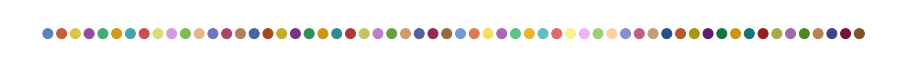

In [22]:
fig = plt.figure(figsize=(16,1))
plt.scatter(range(len(palette)), [1]*len(palette), c=palette, s=100)
plt.axis("off")
plt.show()

In [23]:
base_names = ["blue", "vermillion", "yellow", "purple", "green", "gold", "teal", "red", 
              "chartreuse", "lavendar", "lime", "orange", "indigo", "magenta", "brown"]
dark_names = ["dark_" + name for name in base_names]
light_names = ["light_" + name for name in base_names]
darker_names = ["darker_" + name for name in base_names]
palette_names = base_names + dark_names + light_names + darker_names
palette_names = ["nke_" + name for name in palette_names]
len(palette_names)

60

In [24]:
palette_names

['nke_blue',
 'nke_vermillion',
 'nke_yellow',
 'nke_purple',
 'nke_green',
 'nke_gold',
 'nke_teal',
 'nke_red',
 'nke_chartreuse',
 'nke_lavendar',
 'nke_lime',
 'nke_orange',
 'nke_indigo',
 'nke_magenta',
 'nke_brown',
 'nke_dark_blue',
 'nke_dark_vermillion',
 'nke_dark_yellow',
 'nke_dark_purple',
 'nke_dark_green',
 'nke_dark_gold',
 'nke_dark_teal',
 'nke_dark_red',
 'nke_dark_chartreuse',
 'nke_dark_lavendar',
 'nke_dark_lime',
 'nke_dark_orange',
 'nke_dark_indigo',
 'nke_dark_magenta',
 'nke_dark_brown',
 'nke_light_blue',
 'nke_light_vermillion',
 'nke_light_yellow',
 'nke_light_purple',
 'nke_light_green',
 'nke_light_gold',
 'nke_light_teal',
 'nke_light_red',
 'nke_light_chartreuse',
 'nke_light_lavendar',
 'nke_light_lime',
 'nke_light_orange',
 'nke_light_indigo',
 'nke_light_magenta',
 'nke_light_brown',
 'nke_darker_blue',
 'nke_darker_vermillion',
 'nke_darker_yellow',
 'nke_darker_purple',
 'nke_darker_green',
 'nke_darker_gold',
 'nke_darker_teal',
 'nke_darker_re

In [25]:
offsets = [int(v) for v in np.linspace(50, -50, 21)]
viewer_palettes = {}
for color, name in zip(palette, palette_names):
    color_gradient = []
    for offset in offsets:
        color_gradient.append(color_variant(color, brightness_offset=offset, return_format="hex"))
    viewer_palettes[name] = color_gradient
viewer_palettes

{'nke_blue': ['#8db3ef',
  '#88aeea',
  '#83a9e5',
  '#7ea4e0',
  '#799fdb',
  '#749ad6',
  '#6f95d1',
  '#6a90cc',
  '#658bc7',
  '#6086c2',
  '#5b81bd',
  '#567cb8',
  '#5177b3',
  '#4c72ae',
  '#476da9',
  '#4268a4',
  '#3d639f',
  '#385e9a',
  '#335995',
  '#2e5490',
  '#294f8b'],
 'nke_vermillion': ['#f39369',
  '#ee8e64',
  '#e9895f',
  '#e4845a',
  '#df7f55',
  '#da7a50',
  '#d5754b',
  '#d07046',
  '#cb6b41',
  '#c6663c',
  '#c16137',
  '#bc5c32',
  '#b7572d',
  '#b25228',
  '#ad4d23',
  '#a8481e',
  '#a34319',
  '#9e3e14',
  '#b9592f',
  '#b8582e',
  '#b7572d'],
 'nke_yellow': ['#fff679',
  '#fff174',
  '#ffec6f',
  '#ffe76a',
  '#fae265',
  '#f5dd60',
  '#f0d85b',
  '#ebd356',
  '#e6ce51',
  '#e1c94c',
  '#dcc447',
  '#d7bf42',
  '#d2ba3d',
  '#cdb538',
  '#c8b033',
  '#c3ab2e',
  '#bea629',
  '#b9a124',
  '#b49c1f',
  '#af971a',
  '#aa9215'],
 'nke_purple': ['#c47fd2',
  '#bf7acd',
  '#ba75c8',
  '#b570c3',
  '#b06bbe',
  '#ab66b9',
  '#a661b4',
  '#a15caf',
  '#9c57aa',
  '

## Plot word clouds of term lists

In [26]:
for k in range(2, n_colors + 1):
    lists, circuits = ontology.load_ontology(k, suffix=suffix)
    lists["DOMAIN"] = [k2name[k][i] for i in lists["CLUSTER"]]
    lists_ordered = pd.DataFrame()
    for name in k2name_ordered[k]:
        lists_ordered = lists_ordered.append(lists.loc[lists["DOMAIN"] == name])
    k_names = [name.upper().replace(" ", "_") for name in k2name_ordered[k]]
    lists_ordered["DOMAIN"] = [name.upper().replace(" ", "_") for name in lists_ordered["DOMAIN"]]
    ontology.plot_wordclouds("figures/lists/kvals{}".format(suffix), k_names, lists_ordered, metric="R", 
                             path="", suffix="/k{:02d}".format(k), palette=palette,
                             height=350, width=260, min_font_size=0, max_font_size=50,
                             brightness_offset=0.15, darkness_offset=-0.35, n_offsets=25,
                             print_fig=False)

## Plot brain maps of circuits

In [27]:
import os

In [28]:
atlas = utilities.load_atlas()
cmaps = style.colormaps["data-driven"] + style.colormaps["dsm"]

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


----------------------------------------------------------------------
k = 2
----------------------------------------------------------------------
AROUSAL              Min: 0.0000  Mean: 0.0495  Max: 0.3682


/anaconda3/envs/ontol/lib/python3.6/site-packages/nilearn/plotting/displays.py:1582: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


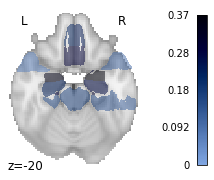

MANIPULATION         Min: 0.0000  Mean: 0.0254  Max: 0.1119


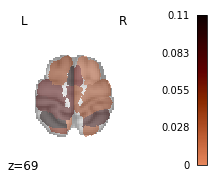

----------------------------------------------------------------------
k = 3
----------------------------------------------------------------------
AROUSAL              Min: 0.0000  Mean: 0.0491  Max: 0.3757


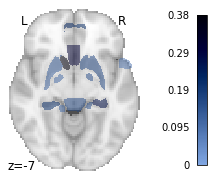

MANIPULATION         Min: 0.0000  Mean: 0.0220  Max: 0.1383


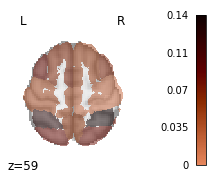

LANGUAGE             Min: 0.0000  Mean: 0.0325  Max: 0.3119


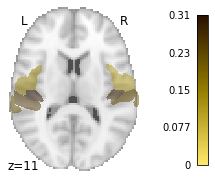

----------------------------------------------------------------------
k = 4
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0375  Max: 0.3416


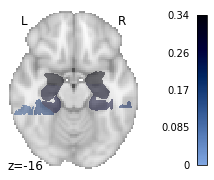

AROUSAL              Min: 0.0000  Mean: 0.0518  Max: 0.5237


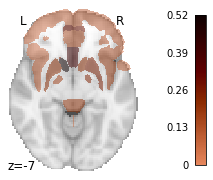

VISION               Min: 0.0000  Mean: 0.0290  Max: 0.1768


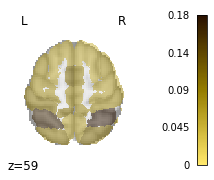

LANGUAGE             Min: 0.0000  Mean: 0.0478  Max: 0.4481


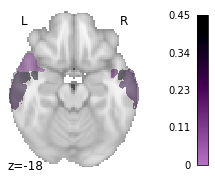

----------------------------------------------------------------------
k = 5
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0406  Max: 0.4352


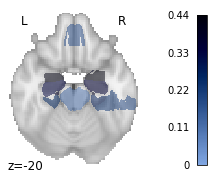

REWARD               Min: 0.0000  Mean: 0.0423  Max: 0.7784


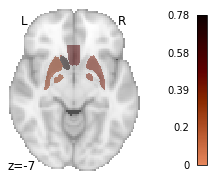

VISION               Min: 0.0000  Mean: 0.0247  Max: 0.2040


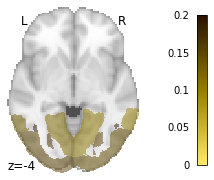

MANIPULATION         Min: 0.0000  Mean: 0.0203  Max: 0.1397


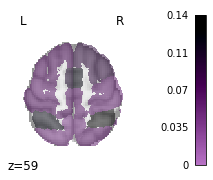

LANGUAGE             Min: 0.0000  Mean: 0.0401  Max: 0.3730


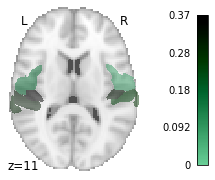

----------------------------------------------------------------------
k = 6
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0334  Max: 0.3838


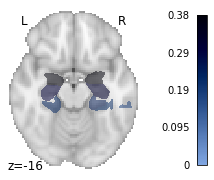

REWARD               Min: 0.0000  Mean: 0.0472  Max: 0.6756


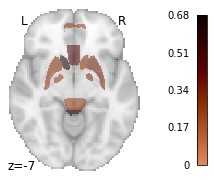

COGNITION            Min: 0.0000  Mean: 0.0072  Max: 0.0785


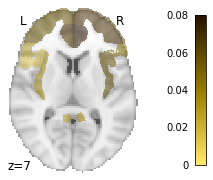

VISION               Min: 0.0000  Mean: 0.0257  Max: 0.2105


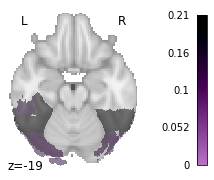

MANIPULATION         Min: 0.0000  Mean: 0.0259  Max: 0.1881


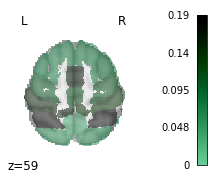

LANGUAGE             Min: 0.0000  Mean: 0.0408  Max: 0.4010


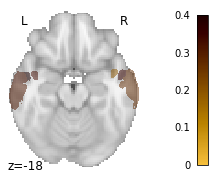

----------------------------------------------------------------------
k = 7
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0214  Max: 0.2986


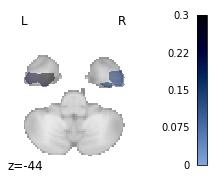

EMOTION              Min: 0.0000  Mean: 0.0255  Max: 0.5408


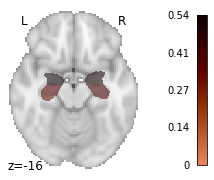

REWARD               Min: 0.0000  Mean: 0.0168  Max: 0.4342


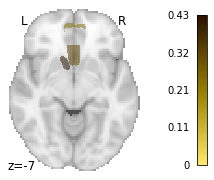

AROUSAL              Min: 0.0000  Mean: 0.0278  Max: 0.2295


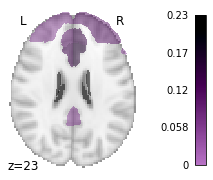

VISION               Min: 0.0000  Mean: 0.0216  Max: 0.1598


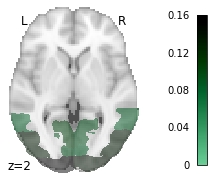

MANIPULATION         Min: 0.0000  Mean: 0.0269  Max: 0.1950


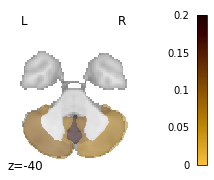

LANGUAGE             Min: 0.0000  Mean: 0.0423  Max: 0.4847


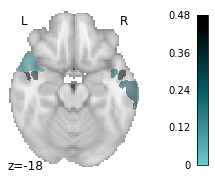

----------------------------------------------------------------------
k = 8
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0178  Max: 0.3551


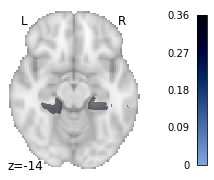

EMOTION              Min: 0.0000  Mean: 0.0255  Max: 0.6188


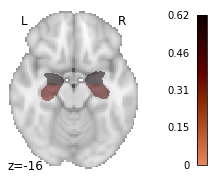

REWARD               Min: 0.0000  Mean: 0.0532  Max: 0.7973


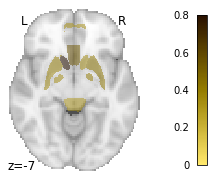

COGNITION            Min: 0.0000  Mean: 0.0086  Max: 0.0934


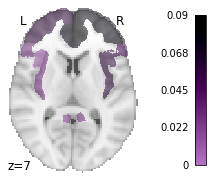

VISION               Min: 0.0000  Mean: 0.0207  Max: 0.1494


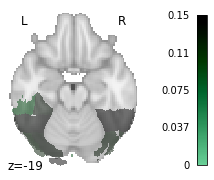

MANIPULATION         Min: 0.0000  Mean: 0.0238  Max: 0.1813


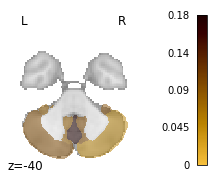

HEARING              Min: 0.0000  Mean: 0.0320  Max: 0.4775


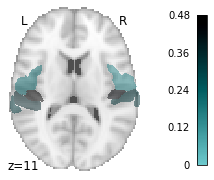

LANGUAGE             Min: 0.0000  Mean: 0.0186  Max: 0.3725


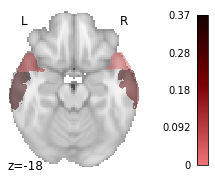

----------------------------------------------------------------------
k = 9
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0369  Max: 0.4714


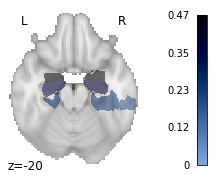

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0115  Max: 0.1266


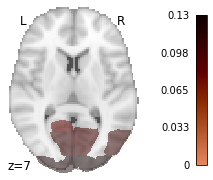

REWARD               Min: 0.0000  Mean: 0.0521  Max: 0.7425


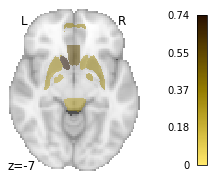

COGNITION            Min: 0.0000  Mean: 0.0125  Max: 0.1000


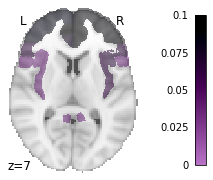

VISION               Min: 0.0000  Mean: 0.0129  Max: 0.2000


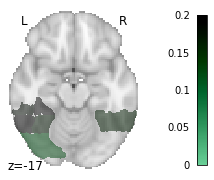

MANIPULATION         Min: 0.0000  Mean: 0.0131  Max: 0.1582


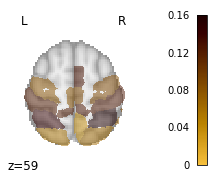

EXECUTION            Min: 0.0000  Mean: 0.0081  Max: 0.2446


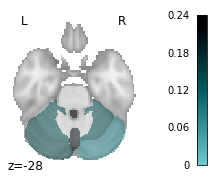

HEARING              Min: 0.0000  Mean: 0.0244  Max: 0.3519


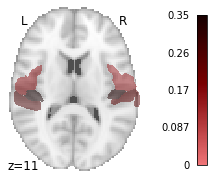

LANGUAGE             Min: 0.0000  Mean: 0.0154  Max: 0.3256


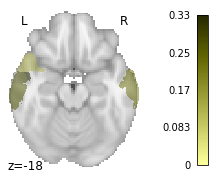

----------------------------------------------------------------------
k = 10
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0158  Max: 0.3476


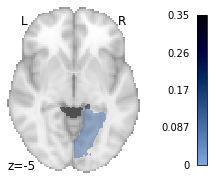

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0114  Max: 0.3193


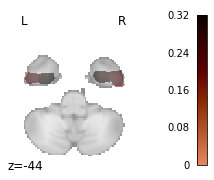

EMOTION              Min: 0.0000  Mean: 0.0256  Max: 0.6236


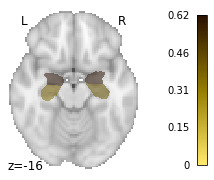

REWARD               Min: 0.0000  Mean: 0.0528  Max: 0.8092


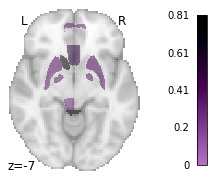

COGNITIVE_PROCESS    Min: 0.0000  Mean: 0.0093  Max: 0.1166


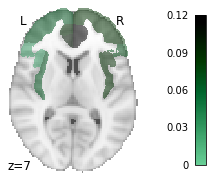

VISION               Min: 0.0000  Mean: 0.0205  Max: 0.2014


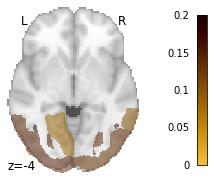

MANIPULATION         Min: 0.0000  Mean: 0.0232  Max: 0.2219


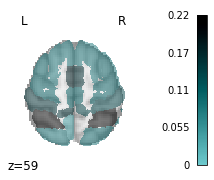

EXECUTION            Min: 0.0000  Mean: 0.0081  Max: 0.2338


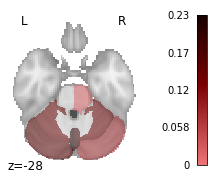

HEARING              Min: 0.0000  Mean: 0.0186  Max: 0.3018


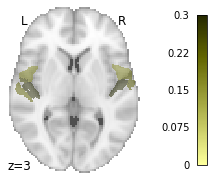

LANGUAGE             Min: 0.0000  Mean: 0.0179  Max: 0.3191


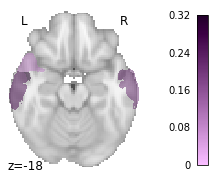

----------------------------------------------------------------------
k = 11
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0038  Max: 0.2476


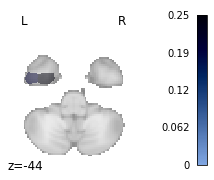

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0104  Max: 0.2526


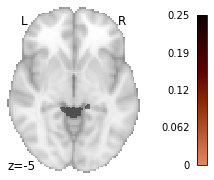

EMOTION              Min: 0.0000  Mean: 0.0226  Max: 0.5571


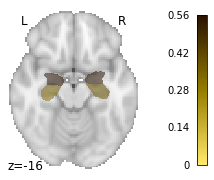

REWARD               Min: 0.0000  Mean: 0.0120  Max: 0.7291


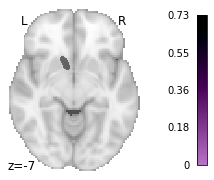

AROUSAL              Min: 0.0000  Mean: 0.0118  Max: 0.3921


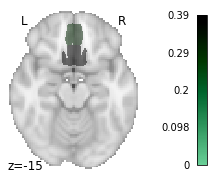

REACTION_TIME        Min: 0.0000  Mean: 0.0221  Max: 0.1835


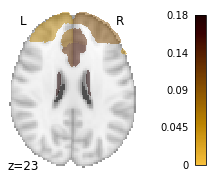

VISION               Min: 0.0000  Mean: 0.0158  Max: 0.1439


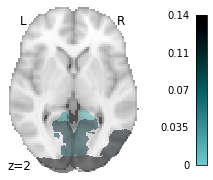

MANIPULATION         Min: 0.0000  Mean: 0.0277  Max: 0.2328


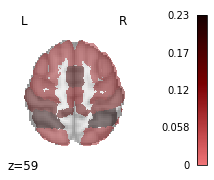

PERCEPTION           Min: 0.0000  Mean: 0.0274  Max: 0.4138


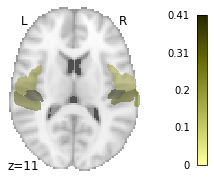

LANGUAGE             Min: 0.0000  Mean: 0.0153  Max: 0.3199


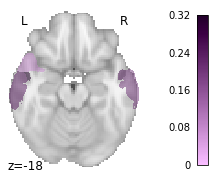

WORD                 Min: 0.0000  Mean: 0.0137  Max: 0.2576


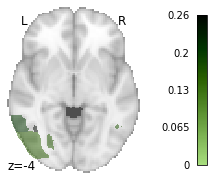

----------------------------------------------------------------------
k = 12
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0195  Max: 0.3138


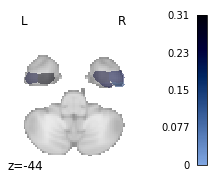

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0111  Max: 0.1557


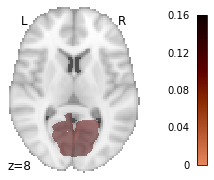

EMOTION              Min: 0.0000  Mean: 0.0253  Max: 0.6090


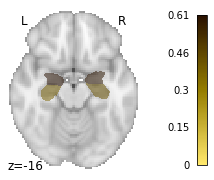

REWARD               Min: 0.0000  Mean: 0.0162  Max: 0.7402


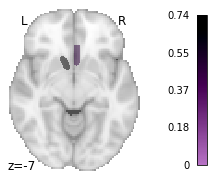

ANTICIPATION         Min: 0.0000  Mean: 0.0247  Max: 0.5224


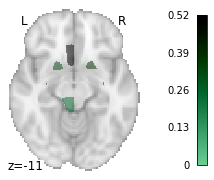

REACTION_TIME        Min: 0.0000  Mean: 0.0172  Max: 0.2283


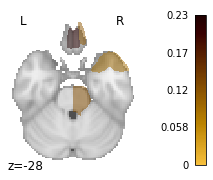

REPRESENTATION       Min: 0.0000  Mean: 0.0156  Max: 0.1783


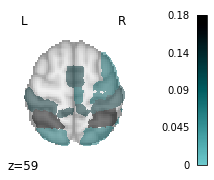

VISION               Min: 0.0000  Mean: 0.0223  Max: 0.2671


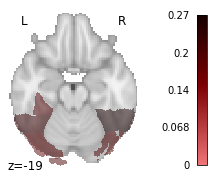

MANIPULATION         Min: 0.0000  Mean: 0.0067  Max: 0.1561


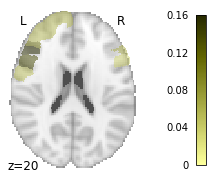

EXECUTION            Min: 0.0000  Mean: 0.0090  Max: 0.2504


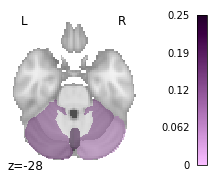

HEARING              Min: 0.0000  Mean: 0.0177  Max: 0.3289


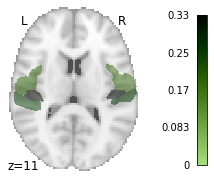

LANGUAGE             Min: 0.0000  Mean: 0.0255  Max: 0.4178


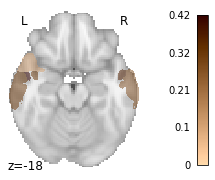

----------------------------------------------------------------------
k = 13
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0137  Max: 0.2919


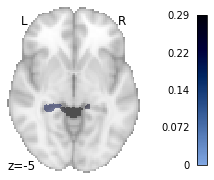

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0089  Max: 0.3017


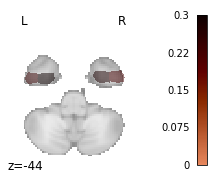

RECOGNITION          Min: 0.0000  Mean: 0.0184  Max: 0.1882


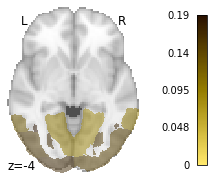

EMOTION              Min: 0.0000  Mean: 0.0156  Max: 0.5243


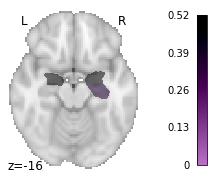

REWARD               Min: 0.0000  Mean: 0.0117  Max: 0.7081


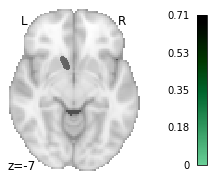

AROUSAL              Min: 0.0000  Mean: 0.0118  Max: 0.3832


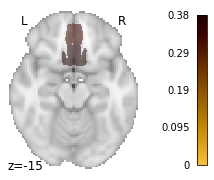

ANTICIPATION         Min: 0.0000  Mean: 0.0184  Max: 0.2338


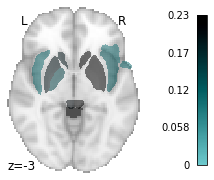

REACTION_TIME        Min: 0.0000  Mean: 0.0065  Max: 0.1123


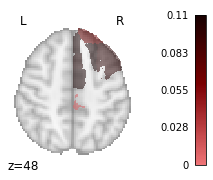

VISION               Min: 0.0000  Mean: 0.0147  Max: 0.2013


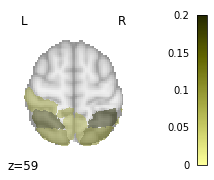

MANIPULATION         Min: 0.0000  Mean: 0.0082  Max: 0.1643


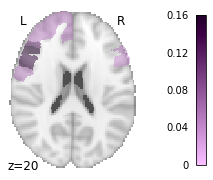

EXECUTION            Min: 0.0000  Mean: 0.0089  Max: 0.2544


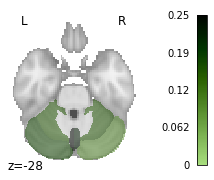

HEARING              Min: 0.0000  Mean: 0.0342  Max: 0.5352


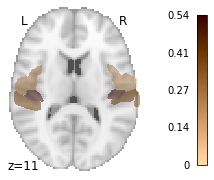

LANGUAGE             Min: 0.0000  Mean: 0.0194  Max: 0.3426


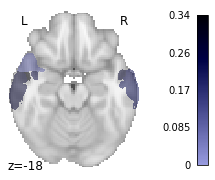

----------------------------------------------------------------------
k = 14
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0122  Max: 0.2361


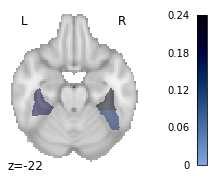

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0061  Max: 0.2885


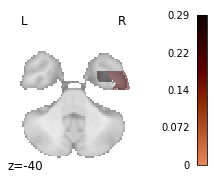

RETRIEVAL            Min: 0.0000  Mean: 0.0042  Max: 0.2735


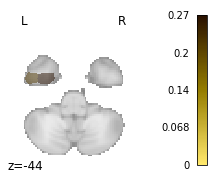

EMOTION              Min: 0.0000  Mean: 0.0191  Max: 0.3657


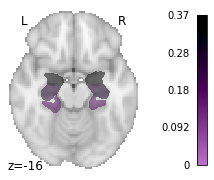

REWARD               Min: 0.0000  Mean: 0.0263  Max: 0.6273


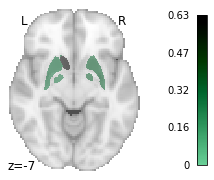

AROUSAL              Min: 0.0000  Mean: 0.0131  Max: 0.4280


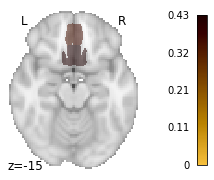

ANTICIPATION         Min: 0.0000  Mean: 0.0120  Max: 0.1835


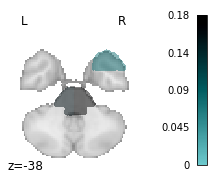

COGNITION            Min: 0.0000  Mean: 0.0075  Max: 0.1232


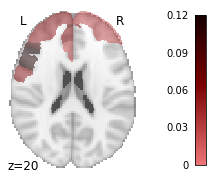

VISION               Min: 0.0000  Mean: 0.0140  Max: 0.2124


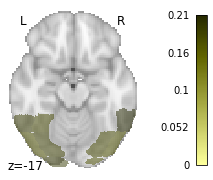

MANIPULATION         Min: 0.0000  Mean: 0.0196  Max: 0.2542


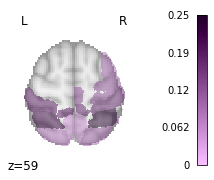

EXECUTION            Min: 0.0000  Mean: 0.0087  Max: 0.2578


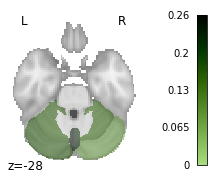

LANGUAGE             Min: 0.0000  Mean: 0.0276  Max: 0.3681


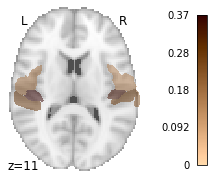

WORD                 Min: 0.0000  Mean: 0.0084  Max: 0.2553


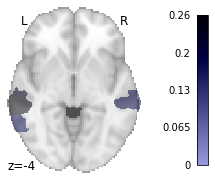

SPEECH               Min: 0.0000  Mean: 0.0088  Max: 0.4299


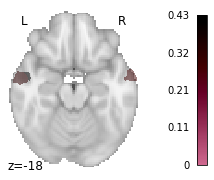

----------------------------------------------------------------------
k = 15
----------------------------------------------------------------------
MEMORY               Min: 0.0000  Mean: 0.0090  Max: 0.3045


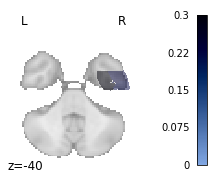

EPISODIC_MEMORY      Min: 0.0000  Mean: 0.0097  Max: 0.3196


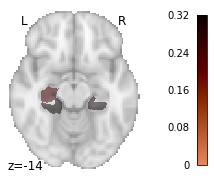

FAMILIARITY          Min: 0.0000  Mean: 0.0108  Max: 0.2269


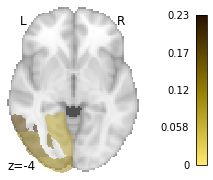

RECALL               Min: 0.0000  Mean: 0.0074  Max: 0.1285


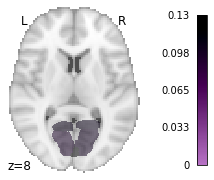

EMOTION              Min: 0.0000  Mean: 0.0205  Max: 0.5988


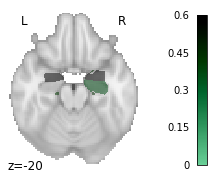

REWARD               Min: 0.0000  Mean: 0.0137  Max: 0.2941


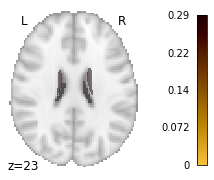

AROUSAL              Min: 0.0000  Mean: 0.0123  Max: 0.3998


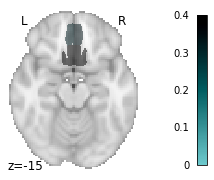

ANTICIPATION         Min: 0.0000  Mean: 0.0122  Max: 0.7340


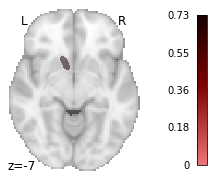

COGNITIVE_PROCESS    Min: 0.0000  Mean: 0.0125  Max: 0.1234


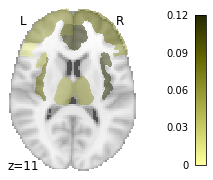

VISION               Min: 0.0000  Mean: 0.0065  Max: 0.1209


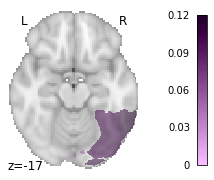

MANIPULATION         Min: 0.0000  Mean: 0.0242  Max: 0.2362


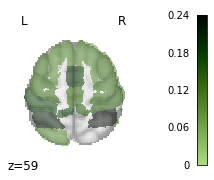

EXECUTION            Min: 0.0000  Mean: 0.0087  Max: 0.2615


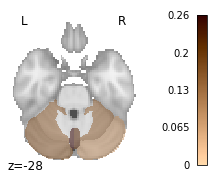

HEARING              Min: 0.0000  Mean: 0.0331  Max: 0.5453


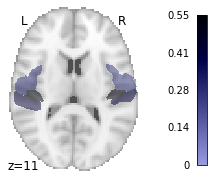

LANGUAGE             Min: 0.0000  Mean: 0.0174  Max: 0.3296


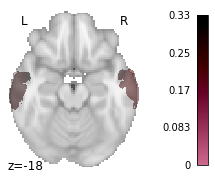

WORD                 Min: 0.0000  Mean: 0.0061  Max: 0.2579


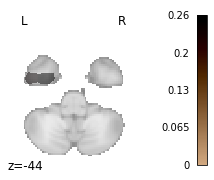

In [29]:
for k in range(2, n_colors + 1):
    
    print("-" * 70 + "\nk = {}\n".format(k) + "-" * 70)
    
    path = "figures/circuits/kvals{}/k{:02}".format(suffix, k)
    if not os.path.exists(path):
        os.makedirs(path)
    
    lists, circuits = ontology.load_ontology(k, suffix=suffix)
    scores = utilities.score_lists(lists, dtm_bin, label_var="DOMAIN").loc[act_bin.index]
    
    pmi = ontology.compute_cooccurrences(act_bin, scores, positive=True)
    pmi = ontology.threshold_pmi_by_circuits(pmi, circuits, label_var="DOMAIN")
    
    pmi.columns = [str(column) for column in pmi.columns]
    k_names = [name.upper().replace(" ", "_") for name in k2name_ordered[k]]
    pmi = pmi[k_names]
    
    vmaxs = [round(v, 2) for v in pmi.max()]
    
    utilities.map_plane(pmi, atlas, path, suffix="_z", cmaps=cmaps, vmaxs=vmaxs, cut_coords=1,
                        plane="z", cbar=True, verbose=True, print_fig=True)